In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

2025-08-27 12:57:28.161142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756299448.327134      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756299448.373794      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_ds = image_dataset_from_directory(
    directory='/kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256), 
    validation_split=0.2, 
    subset="training", 
    seed=1111)

val_ds = image_dataset_from_directory(
    directory='/kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256), 
    validation_split=0.2, 
    subset="validation",
    seed=1111)

Found 16242 files belonging to 10 classes.
Using 12994 files for training.


I0000 00:00:1756299472.962665      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 16242 files belonging to 10 classes.
Using 3248 files for validation.


In [3]:
class_names = train_ds.class_names

for images, labels in train_ds.take(1):
    images_np = images.numpy().astype("uint8")
    labels_np = labels.numpy()
    
    idxs = np.random.choice(len(images_np), size=25, replace=False)
    
    plt.figure(figsize=(25, 25))
    for i, idx in enumerate(idxs):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images_np[idx])
        
        class_id = np.argmax(labels_np[idx])
        plt.title(class_names[class_id])
        plt.axis("off")

In [15]:
inp = Input((256, 256, 3))
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=inp   
)
x = base_model.output
x = GlobalMaxPooling2D(name="Global-Max-Pooling")(x)
x = Dense(128, activation="relu", name="Hidden-1")(x)
x = Dropout(0.3, name="Dropout-1")(x)
output = Dense(len(class_names), activation="softmax", name="output")(x)

model = Model(inputs=inp, outputs=output)

model.summary()  

/tmp/ipykernel_36/807312634.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 2,389,130 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [16]:
model.compile(optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5), loss=CategoricalFocalCrossentropy(alpha=0.5), metrics=[Recall(name="recall"), Precision(name="precision"),
                  AUC(name='prauc', curve='PR'), AUC(name='auroc', curve='ROC'), "accuracy"])

In [17]:
!mkdir models
chkp = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/models/model.keras",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

mkdir: cannot create directory ‘models’: File exists


In [18]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[chkp])

Epoch 1/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 142s 210ms/step - accuracy: 0.3851 - auroc: 0.7788 - loss: 1.0977 - prauc: 0.3402 - precision: 0.4726 - recall: 0.2343 - val_accuracy: 0.1949 - val_auroc: 0.7167 - val_loss: 1.5108 - val_prauc: 0.1917 - val_precision: 0.1999 - val_recall: 0.1721
Epoch 2/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 65s 161ms/step - accuracy: 0.6386 - auroc: 0.9449 - loss: 0.2960 - prauc: 0.7099 - precision: 0.7693 - recall: 0.4487 - val_accuracy: 0.3322 - val_auroc: 0.8053 - val_loss: 1.0564 - val_prauc: 0.3147 - val_precision: 0.3525 - val_recall: 0.2931
Epoch 3/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 65s 161ms/step - accuracy: 0.7199 - auroc: 0.9697 - loss: 0.1946 - prauc: 0.8144 - precision: 0.8182 - recall: 0.5798 - val_accuracy: 0.5043 - val_auroc: 0.8926 - val_loss: 0.6053 - val_prauc: 0.5316 - val_precision: 0.5465 - val_recall: 0.4563
Epoch 4/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 65s 160ms/step - accuracy: 0.7642 - auroc: 0.9782 - loss: 0.1514 - prauc: 0.8557 - precision: 0.8347 - r

In [21]:
model = load_model("/kaggle/working/models/model.keras")

In [22]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [59]:
sample=1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


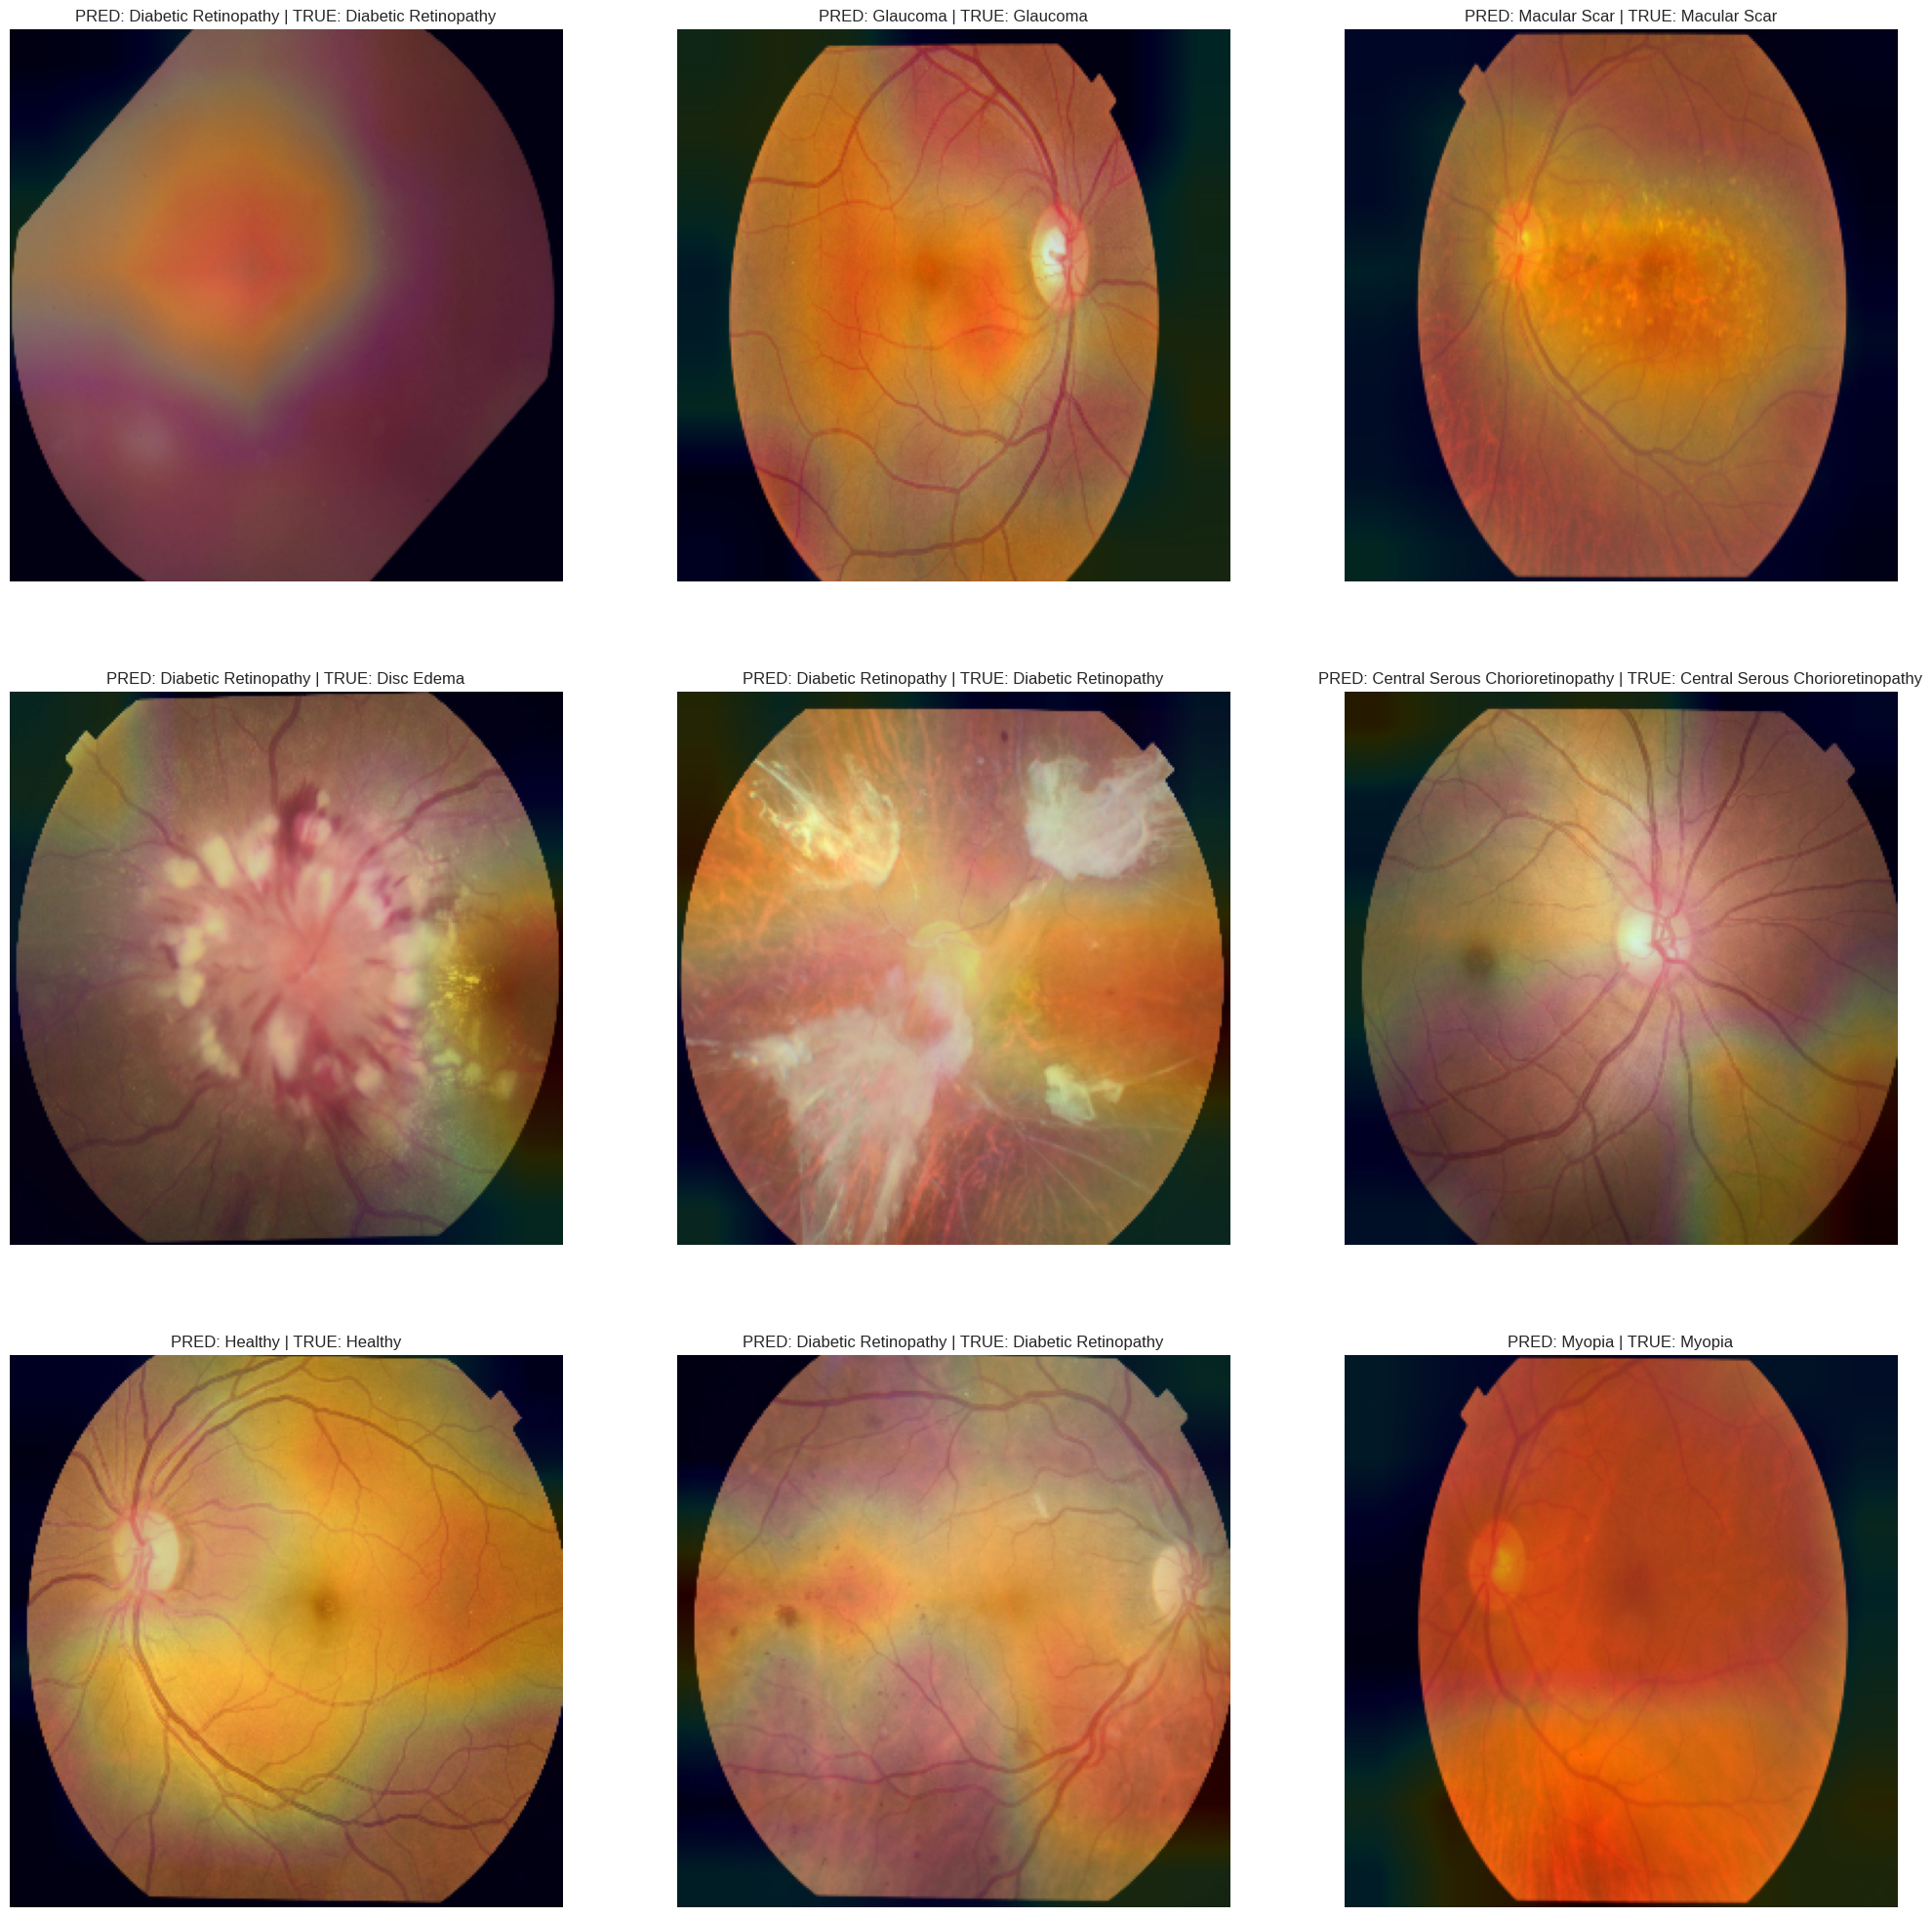

In [63]:
for images, labels in val_ds.take(1):
    images_np = images.numpy()
    labels_np = labels.numpy()
    pred = model.predict(images_np)

    idxs = np.random.choice(len(images_np), size=9, replace=False)
    plt.figure(figsize=(25, 25))

    for i, idx in enumerate(idxs):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images_np[idx].astype("uint8"))

        gradcam = make_gradcam_heatmap(
            np.expand_dims(images_np[idx], axis=0),
            model,
            "Conv_1"
        )
        gradcam = tf.image.resize(gradcam[..., tf.newaxis], (256, 256)).numpy().squeeze()
        gradcam = cv2.blur(gradcam, (3, 3))
        gradcam = gradcam / gradcam.max()  

        plt.imshow(gradcam, cmap="jet", alpha=0.15)

        class_id = np.argmax(labels_np[idx])
        pred_id = np.argmax(pred[idx])
        plt.title(f'PRED: {class_names[pred_id]} | TRUE: {class_names[class_id]}')
        plt.axis("off")
plt.savefig(f"{sample}_retinas.png")
sample+=1

In [66]:
class_names

['Central Serous Chorioretinopathy',
 'Diabetic Retinopathy',
 'Disc Edema',
 'Glaucoma',
 'Healthy',
 'Macular Scar',
 'Myopia',
 'Pterygium',
 'Retinal Detachment',
 'Retinitis Pigmentosa']

In [34]:
hist = history.history
loss = hist["loss"]
val_loss = hist["val_loss"]

recall = hist["recall"]
val_recall = hist["val_recall"]

precision = hist["precision"]
val_precision = hist["val_precision"]

acc = hist["accuracy"]
val_acc = hist["val_accuracy"]

auroc = hist["auroc"]
val_auroc = hist["val_auroc"]

pr_auc = hist["prauc"]
val_pr_auc = hist["val_prauc"]

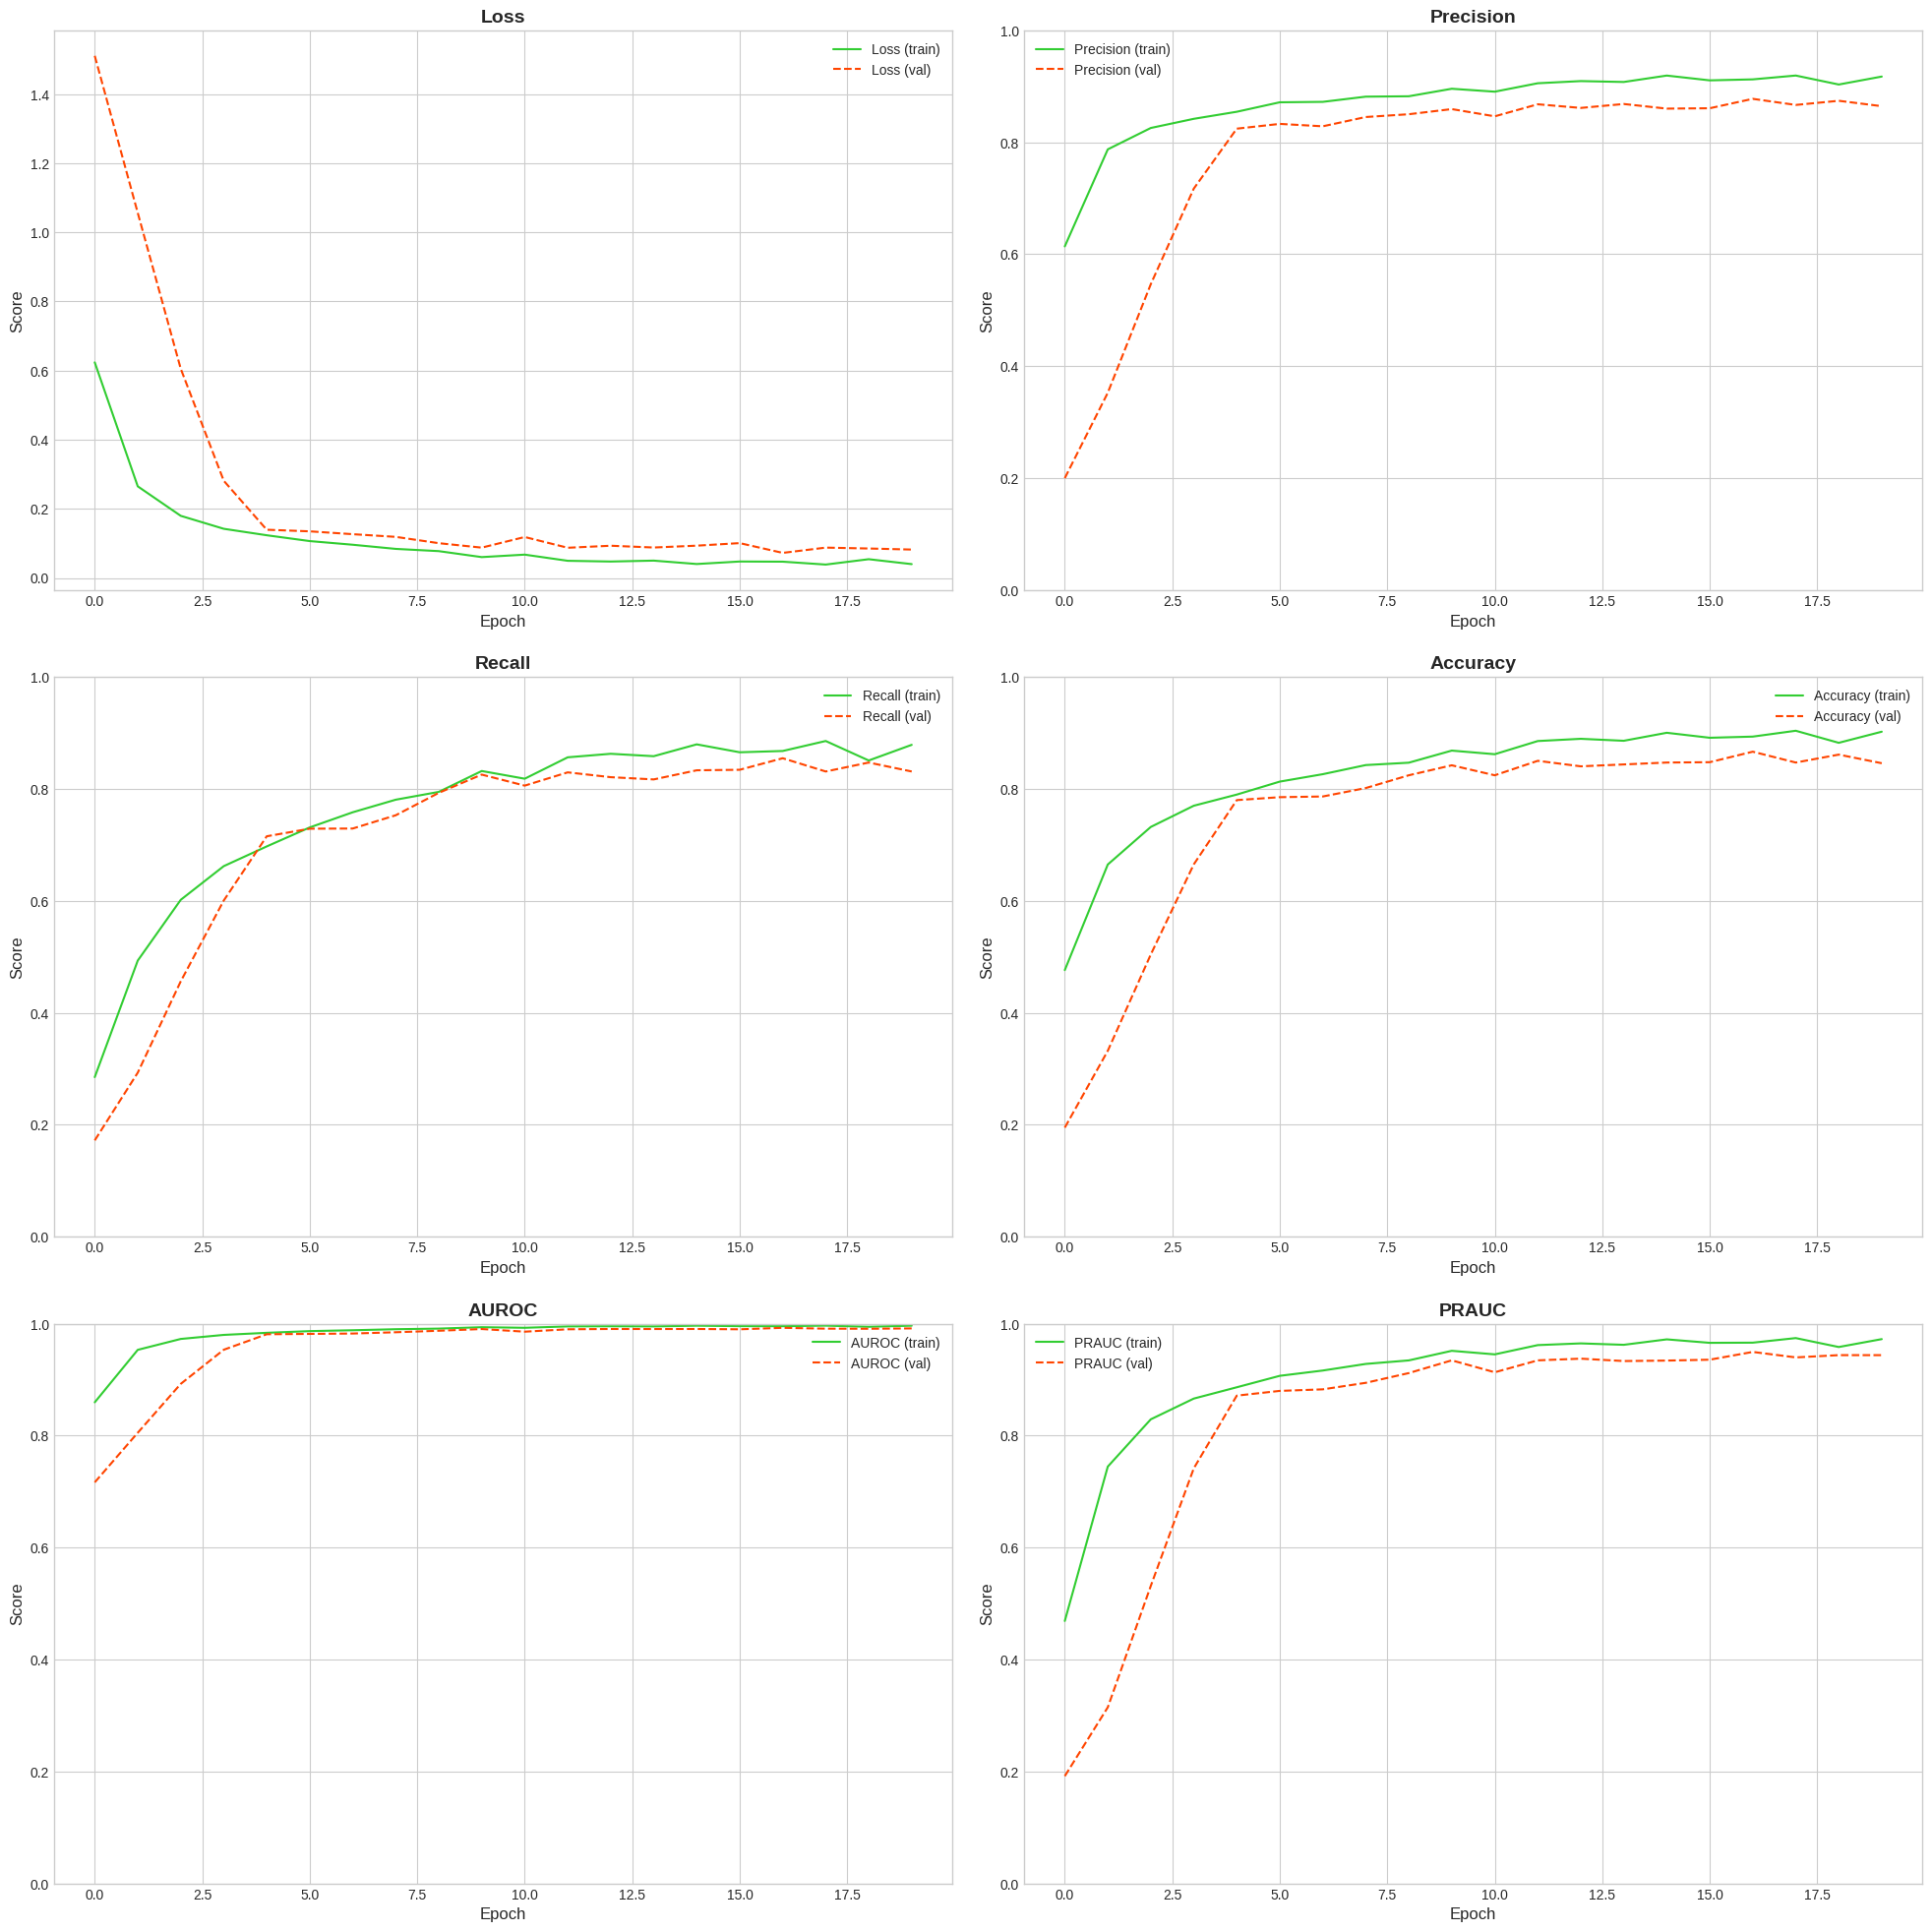

In [48]:
metrics = {
    "Loss": (loss, val_loss),
    "Precision": (precision, val_precision),
    "Recall": (recall, val_recall),
    "Accuracy": (acc, val_acc),
    "AUROC": (auroc, val_auroc),
    "PRAUC": (pr_auc, val_pr_auc),
}
epochs_range = range(len(loss))

colors = ["#32cd32", "#ff4500"]  
styles = ["-", "--"]

# --- Plot ---
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
plt.style.use('seaborn-v0_8-whitegrid')  

axes = axes.flatten()

for ax, (name, (train_metric, val_metric)) in zip(axes, metrics.items()):
    ax.plot(epochs_range, train_metric, label=f"{name} (train)", color=colors[0], linestyle=styles[0])
    ax.plot(epochs_range, val_metric, label=f"{name} (val)", color=colors[1], linestyle=styles[1])

    ax.set_title(name, fontsize=14, weight='bold')
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True)

    if name.lower() != "loss":   
        ax.set_ylim((0, 1))

for ax in axes[len(metrics):]:
    ax.axis("off")

plt.tight_layout(pad=2.0)
plt.savefig("plots_retina.png")
plt.show()
